#### import module

In [1]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Alignment
import glob
import os
import shutil
from io import BytesIO
import subprocess
import time
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
# pubchem検索
import pubchempy as pcp
from PIL import Image
# pubmed検索
from Bio import Entrez
Entrez.email = "seika.oiwa.3590@idemitsu.com"

#### <font color = "red"> (Prog1) </font> Download Genome Data from NCBI

In [225]:
def get_genome(species,group,base_path):
    """We could get Genome Data（**.gbff.gz) submitted Bacterial name from NCBI DB
       Create Folder named Bacterial name and storage Genome Data
       If there is no Genome Data in NCBI DB, remove Folder
    
    Parameters:
    ----------
    species: str
       生物名 (ex. Bacillus subtilis)
    group: str
       bacteria or fungi or plant name 
    base_path: str
       Antismashフォルダパス (ex. /home/***/notebooks/Mydata_analysis/Antismash)
       
    Returns:
    --------
    registration: str
       ゲノム情報登録の有無
    """
    # Create Folder named Bacterial name
    sfname = species.replace(' ','_')
    genome_fpath = f'{base_path}/Genome/{sfname}'
    
    # Request bacterial name to NCBI DB using API and Get Genome Data. It is stored tmp folder
    target = '"'+species+'"'+' '+group
    subprocess.run(f'ncbi-genome-download -g {target} --refseq-categories representative,reference -F genbank -o tmp',shell=True)
    
    # Download data has lots of Unnecessary data, extract necessary data and transrate to Created Folder above
    if os.path.isdir(f'{base_path}/tmp'):
        fpath = glob.glob(f'{base_path}/tmp/**/*.gz',recursive=True)[0]
        if os.path.isfile(fpath):
            os.makedirs(f'{genome_fpath}',exist_ok=True)
            registration = '有'
            shutil.move(f'{fpath}',f'{genome_fpath}')
            shutil.rmtree(f'{base_path}/tmp')
        else:
            shutil.rmtree(f'{base_path}/tmp')

    return registration

def Search_Genome_by_name(strain_name):
    """Search ncbi genome using strain_name and retun GenBank id
    Prameter:
    --------
    strain_name: str
        your strain name
    Return:
    ------
    find/not_find: str
    genome_id_list: list
    """
    
    query1 = f"{strain_name}[organism] AND RefSeq[filter]"
    query2 = f"{strain_name}[organism] AND WGS[filter]"

    handle = Entrez.esearch(db = "nucleotide" ,term = query1)
    record = Entrez.read(handle)
    
    if not record["IdList"]:
        handle = Entrez.esearch(db = "nucleotide" ,term = query2)
        record = Entrez.read(handle)
        
        if not record["IdList"]:
            return "find_genome",record["IdList"]
        else:
            return "not_find", record["IdList"]
    else:
        return "find", record["IdList"]

def Download_genome(genbank_id,folder_path,file_name):
    """Download the genome related to genbank_id
    Parameter:
    ---------
    genbank_id: str
    folder_path: str
        path to the folder download genome_file
    file_name: str
        genome_file save name
    """
    present_path = os.getcwd()
    file_path = f"{present_path}/{genbank_id}.gbk"
    
    subprocess.run(f'ncbi-acc-download {genbank_id}',shell=True)
    
    if file_path:
        shutil.move(file_path,f"{folder_path}/{file_name}.gbk")
        
        return "finish_download_genome"

#### <font color = "red"> (Prog2) </font> AntiSmash analysis

In [12]:
def make_output_data(dataframe,folder_path,save_name):
    """Creating 2D structre from smiles is in dataframe and put 2D sturucure into Dataframe.
       Dataframe is saved xlsx named "Bacterial_list.xlsx"

    Prameters:
    ----------
    dataframe: DataFrame
        dataframe has smiles data in colums name "smiles"
    folder_path: str
        Folder path saving result_data(Bacterial_list.xlsx)
    save_name: str
        save fale name (without extension)

    Returns:
    -------
    dataframe2: DataFrame
    """
    
    dataframe2 = dataframe.fillna('')
    
    # Create 2D structure from smiles using PandasTools
    dataframe['Structure']=''
    PandasTools.AddMoleculeColumnToFrame(dataframe2,molCol='Structure',smilesCol='smiles')
    
    # Save dataframe as xlsx
    PandasTools.SaveXlsxFromFrame(dataframe2,f'{folder_path}/{save_name}.xlsx',molCol='Structure',size=(150,150))
    
    return dataframe2

def get_smile_data(target_name):
    """Get CanonicalSMILES data from PubChem API
       If thre is no data, return None
    
    Parameters:
    ----------
    target_name: str
        substrate name 
        
    Returns:
    -------
    cid: str
       chemical_id
       
    smiles: str
       smiles
    """
    
    properties = ['CanonicalSMILES']
    
    c = pcp.get_properties(properties, f'{target_name}','name')
    if not c:
        cid=None
        smiles=None
    else:
        df = pd.DataFrame(c)
        # CID,smilesデータ抽出
        cid = df.loc[0,'CID']
        smiles = df.loc[0,'CanonicalSMILES']
        
    return cid,smiles

def add_structure(antismash_result):    
    """Get CanonicalSMILES data from PubChem API
       Add smiles to dataframe
    
    Prameters:
    ---------
    antismash_result: DataFrame
        result from ex_antismash. Dataframe has substrate_name in column('Candidate_metabolite')

    Returns:  
    --------
    antismash_result2: DataFrame
        dataframe with smiles data
    """
    
    smile_list = []

    # Extract substrate name from DataFrame and get smiles data using "get_smile_data"
    for i in range(len(antismash_result)):
        target = antismash_result.loc[i,'Candidate_metabolite']
        
        # Get smiles data
        cid,smiles = get_smile_data(target)

        if cid is not None:
            # リスト追加
            add = [target,cid,smiles]
            smile_list.append(add)

    # smileデータフレーム作成
    add_data = pd.DataFrame(smile_list,columns=['target','CID','smiles'])

    # antismashデータにsmiles追加
    merge_data = pd.merge(antismash_result,add_data,left_on='Candidate_metabolite',right_on='target',how='left')
    antismash_result2 = merge_data[['Bacterial_name','Type','Candidate_metabolite','Similarity','CID','smiles']] 
    
    return antismash_result2

def ex_antismash(result_anti_path,bacterial_name):

    """From Anti_Smash result data conteined various data to create the DataFrame contained necessary data
       like substrate_name and similarity.
       
       Also culcurate the number of gene cluster antismash could figure out 

    Parameterts:
    -----------
    result_anti_path : str
        path to result data folder for Antismash (conteined index.html)
    bacterial_name : str
        bacterial_name submmited to Antismash (add to DataFrame)

    Reterns:
    -------
    antismash_result: DataFrame
        Dataframe contains bacterial_name,types,active_agent and similarity
    total_cluster_num: int
        the total number of gene cluster Antismash figure out
    knw_num: int
        the number of well known gene gluster
    unknw_num: int
        the number of unknown gene cluster
    """

    # if index.html(result data of Anti Smash) is "result_anti_path", read it as DataFrame. 
    if os.path.isfile(f'{result_anti_path}/index.html'):
        result = pd.read_html(f'{result_anti_path}/index.html')

        result_list = []
        total_cluster_num = 0
        knw_num = 0

        # As gene cluster name is bellow column (Most similar known cluster), we could get total number of gene cluster counting for row number.
        # Also unknown gene cluster is "NaN".
        for i in range(0,len(result)):
            data = result[i]
            if 'Most similar known cluster' in data.columns:
                # calculate total number of gene cluster
                total_cluster_num = total_cluster_num + len(data)
                
                # calculate number of well known gene cluster
                data2 = data.dropna(subset=['Most similar known cluster']).reset_index()
                knw_num = knw_num + len(data2)
                
                # extract known gene_cluster_name(Candidate_metabolite), type and similality from DataFrame
                for i2 in range(len(data2)):
                    types = data2.loc[i2,'Type']
                    Candidate_metabolite = data2.loc[i2,'Most similar known cluster']
                    similarity = int(data2.loc[i2,'Similarity'].rstrip('%')) 
            
                    #リストに追加
                    add_data = [bacterial_name,types,Candidate_metabolite,similarity]
                    result_list.append(add_data)
            
        #Create DataFrame of result
        antismash_result_ = pd.DataFrame(result_list,columns=['Bacterial_name','Type','Candidate_metabolite','Similarity'])
       
        # remove duplicate
        antismash_result = antismash_result_.drop_duplicates(subset=['Candidate_metabolite']).reset_index()

        #Remove Anti Smash result data Folder (result_anti_path)
        #Same name folder(tmp) causes error when antismash execute 
        shutil.rmtree(result_anti_path)
    else:
        shutil.rmtree(result_anti_path)
    
    unknw_num = total_cluster_num - knw_num
    
    return antismash_result,total_cluster_num,knw_num, unknw_num

def prepaer_anti_smash(folder_path):
    """Create bacterial_name and genome_data_path list.
       As a premise, Genome data is in the bacterial_name folder. 

    Parameter:
    ---------
    folder_path: str
        path for folder conteins genome data
    
    Returns:
    -------
    bacterial_name_list: list
    genome_path_list: list

    """

    dir_list = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path,f))]
    
    genome_path_list = []
    bacterial_name_list = []

    for b_name in dir_list:      
        # create genome data path
        genome_path = glob.glob(f'{folder_path}/{b_name}/*')    
        genome_path_list.append(genome_path)

        bacterial_name_list.append(b_name)
    
    return bacterial_name_list, genome_path_list

def anti_smash(genome_data_path,bacterial_name,result_path):
    """AntiSmash analysis against Genome_data(**.gbff.gz)
       Return outline and detailed dataframe
       
    Parmeter:
    --------
    genome_data_path: str
        path for genome_data
    bacterial_name: str
        bacterial_name of genome
    result_path: str
        path to the folder storage result_data (bacterial_name.xlsx)
    """
    
    # execute antismash
    subprocess.run(f'antismash {genome_data_path} --cb-knownclusters --output-dir tmp_anti',shell=True)

    # Calculating(predicted number(total,well_known,unknown) 
    antismash_result,total_cluster_num,knw_num,unknw_num = ex_antismash('tmp_anti',bacterial_name)

    # Create outline 
    outline = pd.DataFrame(data=[[bacterial_name,'','','']],
    columns=['Bacterial_name','known_cluster','unknown_cluster','total_cluster']).set_index('Bacterial_name')
    outline.loc[bacterial_name,'known_cluster']=knw_num
    outline.loc[bacterial_name,'unknown_cluster']=unknw_num
    outline.loc[bacterial_name,'total_cluster']=total_cluster_num

    # Get smiles of well_known substance using pubchem API and put into dataframe(antismash_result)       
    antismash_result2 = add_structure(antismash_result)
    antismash_result3 = make_output_data(antismash_result2,result_path,bacterial_name)

    return outline, antismash_result2, antismash_result3

#### <font color = "red"> (Prog3) </font> Predict function

In [4]:
def get_query(keywords,field="[Title/Abstract]"):
    """extract function name from keyowrds list and create query submitted for PubMed
    
    Parameters
    ----------
    keywords: list
        list has function name
    field: str
        search area on Pubmed（default: Title/Abstract)
    Returns
    -------
    "(" + ors + ")": str
    """
    ors = " OR ".join(f"({keyword}{field})" for keyword in keywords)
    return "(" + ors + ")"

def create_query():
    """Create query for search article(Pubmed)
    
    Returns:
    --------
    category: list
        key word list of "func_name_to_query"
        
    func_name_to_query: dict
        機能名と定義（辞書型）ex. {"anti_bacteria/fungi":['antibacterial','antimicrobial','antifungal','antimycotic','fungicide'],,}
    """
    
    # definision of function
    func_name_to_keywords = {
        'anti_bacteria/fungi':['antibacterial','antimicrobial','antifungal','antimycotic','fungicide'],
        'insecticide':['insecticidal','insecticide','pesticide'],
        'herbicide':['herbicide','weed killer','weedkiller'],
        'tickkiller':['acaricidal','tick killer','tickkiller'],
        'virus':['virucidal','antivirus','antiviral'],
    }
    # create query
    func_name_to_query = {
        func_name: get_query(keywords) for func_name, keywords in func_name_to_keywords.items()
    }

    category = list(func_name_to_query.keys())

    return category,func_name_to_query

def ex_pubmed(asdf,col_name,fname_list,sign):
    """Counting for elements within the column (col_name) 
    
    Parameters
    ----------
    asdf: dataframe
    col_name: str
        column name applied for "groupby method"
    fname_list: list
        column name list 
    sign: str
        カウント対象となる要素の表記内容
    Returns
    -------
    ex_p2: dataframe
    """
    data = []
    for i in fname_list:
        exdata = asdf[i].apply(lambda x: 1 if x==sign else 0)
        data.append(exdata)

    tmp_df = pd.DataFrame(data)
    tmp_df2 = tmp_df.T
    tmp_df2[col_name] = asdf[col_name]

    ex_p = tmp_df2.groupby(col_name).sum().reset_index()

    return ex_p

def check_spell(tname):
    """Check for spelling errors
    Parameter:
    tname: str
        search words
    """
    kyw = Entrez.read(Entrez.espell(term=tname))
    kyw2 = kyw['CorrectedQuery']

    return kyw2

def search_articles(search_word, max_results=5):
    
    """Search Paper related keyword in Pubmed(Biological paper DB) and get "Paper id"

    Parameters
    ----------
    serch_word: str
        検索キーワード("target_nane AND [func1 OR func2]")       
    max_results: int
        検索結果の表示数, デフォルト(5件)

    Returns
    -------
    results: dict
    """
    
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax=str(max_results),
                            term=search_word)
    results = Entrez.read(handle,validate=False)
    return results

def fetch_abstract(pub_id_data):

    """Download abstract from paper_id (pubid), and Return dataframe (contains pub_id and abstract)

    Parameters
    ----------
    pub_id_data: dict
        pub_id_data related to search word (using "search_article") 
    
    Returns
    -------
    dataframe: dataframe
    """
    
    data = []
    
    for i in range(len(pub_id_data['IdList'])):
        pmid = pub_id_data['IdList'][i]
    
        handle = Entrez.efetch(db='pubmed', id=pmid, retmode='xml')
        article = Entrez.read(handle)['PubmedArticle'][0]

        try:
            abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
            add = [pmid,abstract]
            data.append(add)
    
        except KeyError as e:
            print('keyError')
            
    dataframe = pd.DataFrame(data,columns=['pubid','Abstract'])
    
    return dataframe

def calculate_data(abdf,keys):
    """Count number of keywords related to function(pesticide) in abstract. 
       If more than 2 papers containing each keywors is found, target substrate is related to keywords

    Prameters:
    ---------
    abdf: dataframe
        dataframe conteins column(pubid,Abstract) created by "fetch_abstract"
    
    """

    if abdf.empty:
        return '-',abdf

    else:
        #Extract each keyword from kyword list
        keys2 = [word.strip('-.()/[]') for word in keys.replace('AND',',').replace('OR',',').replace(' ','').replace('[Title/Abstract]','').split(',')]
        #dataframeにカウント結果入力カラム追加
        abdf[keys2]=''
            
        #Count number of keyword in dabstrac and add num into dataframe
        for i in range(len(abdf)):
            abst_text = [word.strip('-.()/') for word in abdf.loc[i,'Abstract'].lower().split()]
            for k in range(len(keys2)):
                sword = keys2[k]
                ct = abst_text.count(sword)
                abdf.loc[i,sword] = int(ct)
    
        
        #devide key word into target_name and function_name
        target_1 = keys2.pop(0)
        target_2 = keys2.pop(0)
        func_list2 = keys2
        
        #remove abstract contains only target_name or fuction_name
        tmp = abdf[func_list2]
        abdf['sum_func'] = tmp.sum(axis=1)
        abdf2 = abdf[(abdf['sum_func']!=0)]
        abdf3 = abdf2[(abdf2[target_1]!=0) | (abdf2[target_2]!=0)].reset_index()
        
               
        #If more than 2 papers containing each keywors is found, target has function of keywords(describe "Hit")
        
        if len(abdf3) >= 2:
            return 'Hit',abdf
    
        else:
            return '-',abdf

def search_metabolites_in_pubmed(asdf):
    """Submmit target substrate name in the dataframe and function related keywords to Pubmed API,
       and check the paper which has both target substarate name and function related keywords. 
    
    Parameter:
    ----------
    asdf: dataframe
        dataframe is created by "Prog2" (columns:'Candidate_metabolite' conteined)
        
    Return:
    -------
    asdf: dataframe
    raw_data: dataframe
    
    See Also:
    --------
    get_query(keywords,field="[Title/Abstract]")
    check_spell(tname)
    search_articles(serch_word, max_results=5)
    fetch_abstract(result)
    calculate_data(abdf,keys)
    
    """
    # create query
    category,func_name_to_query = create_query()
    
    asdf[category]=''
    
    raw_data = []

    for i in range(len(asdf)):

        tname = asdf.iloc[i]['Candidate_metabolite'].lower()
        # spellcheck
        tname_s = check_spell(tname)

        for func_category in category:

            # create research words
            func_word = func_name_to_query[func_category]
            search_word = f'(({tname_s}[Title/Abstract]) OR ({tname}[Title/Abstract])) AND {func_word}'
            #serarch paper in db(pubmed) usign pubmed API and get paper_id
            result = search_articles(search_word)
            #using paper_id, get abstract data
            abs_df = fetch_abstract(result)
            #analysis abstract and estimate function
            rs,abs_df = calculate_data(abs_df,search_word)
            #Add the analysis result to dataframe created at "prog2"
            asdf.loc[i,func_category]=rs
            
            raw_data.append(abs_df)

    return asdf,raw_data 

### <font color = "red"> Example: </font>  prog1 -> prog2 -> prog3

In [229]:
# Input data for Examle(prog1-prog2)
bacterial_name = "Bacillus subtilis"

#### Prog1

In [230]:
re,id_list = Search_Genome_by_name(bacterial_name)

if re=="find":
    genbank_id = id_list[0]
    folder_path = os.getcwd()
    file_name = bacterial_name.replace(" ","_")

    re2 = Download_genome(genbank_id,folder_path,file_name)
    
    print(re2)

finish_download_genome


#### Prog2

In [231]:
genome_data_path = f"{folder_path}/{file_name}.gbk"
result_F_path = os.getcwd()
bacterial_name = "Bacillus_subtilis"

In [232]:
# execute antismash
outline, result_anti_without_fig, result_anti_with_fig = anti_smash(genome_data_path,bacterial_name,result_F_path)

In [233]:
outline

,known_cluster,unknown_cluster,total_cluster
Bacterial_name,,,
Bacillus_subtilis,7,2,9


/anaconda/envs/antismash/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:120: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Bacterial_name,Type,Candidate_metabolite,Similarity,CID,smiles,Structure
0,Bacillus_subtilis,NRPS,surfactin,86,443592,CC(C)CCCCCCCCCC1CC(=O)NC(C(=O)NC(C(=O)NC(C(=O)...,
1,Bacillus_subtilis,"transAT-PKS,PKS-like,T3PKS,NRPS",bacillaene,100,25144999,CC(C)CC(C(=O)NCC=CC=CC=CC(=CC=CC=C(C)C(CC(=O)N...,
2,Bacillus_subtilis,"NRPS,betalactone",fengycin,100,443591,CCCCCCCCCCCCCC(CC(=O)NC(CCC(=O)O)C(=O)NC(CCCN)...,
3,Bacillus_subtilis,T3PKS,1-carbapen-2-em-3-carboxylic acid,16,441133,C1C=C(N2C1CC2=O)C(=O)O,
4,Bacillus_subtilis,"NRP-metallophore,NRPS",bacillibactin,100,125349,CC1C(C(=O)OC(C(C(=O)OC(C(C(=O)O1)NC(=O)CNC(=O)...,
5,Bacillus_subtilis,sactipeptide,subtilosin A,100,16132390,CCC(C)C(C(=O)NC(C)C(=O)NCC(=O)NC(C)C(=O)NCC(=O...,
6,Bacillus_subtilis,other,bacilysin,100,86583338,CC(C(=O)NC(CC1CCC(=O)C2C1O2)C(=O)O)N,

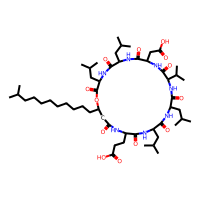
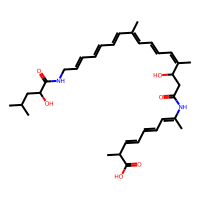
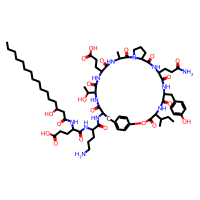
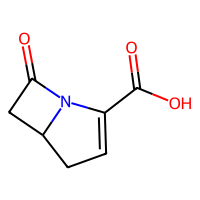
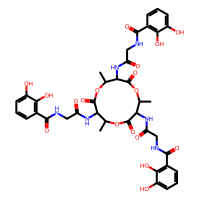
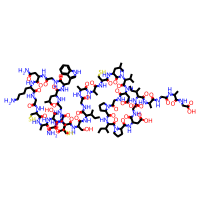
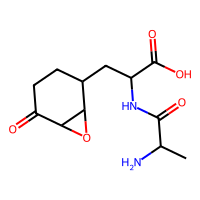

In [234]:
result_anti_with_fig

#### prog3

In [235]:
# research paper
save_name = "anti_paper"
folder_path = os.getcwd()

anti_paper,raw_data = search_metabolites_in_pubmed(result_anti_without_fig)
anti_paper2 = make_output_data(anti_paper,folder_path,save_name)

In [236]:
anti_paper

,Bacterial_name,Type,Candidate_metabolite,Similarity,CID,smiles,Structure,anti_bacteria/fungi,insecticide,herbicide,tickkiller,virus
0,Bacillus_subtilis,NRPS,surfactin,86,443592,CC(C)CCCCCCCCCC1CC(=O)NC(C(=O)NC(C(=O)NC(C(=O)...,,-,Hit,Hit,-,Hit
1,Bacillus_subtilis,"transAT-PKS,PKS-like,T3PKS,NRPS",bacillaene,100,25144999,CC(C)CC(C(=O)NCC=CC=CC=CC(=CC=CC=C(C)C(CC(=O)N...,,-,-,-,-,-
2,Bacillus_subtilis,"NRPS,betalactone",fengycin,100,443591,CCCCCCCCCCCCCC(CC(=O)NC(CCC(=O)O)C(=O)NC(CCCN)...,,-,Hit,-,-,-
3,Bacillus_subtilis,T3PKS,1-carbapen-2-em-3-carboxylic acid,16,441133,C1C=C(N2C1CC2=O)C(=O)O,,-,-,-,-,-
4,Bacillus_subtilis,"NRP-metallophore,NRPS",bacillibactin,100,125349,CC1C(C(=O)OC(C(C(=O)OC(C(C(=O)O1)NC(=O)CNC(=O)...,,Hit,-,-,-,-
5,Bacillus_subtilis,sactipeptide,subtilosin A,100,16132390,CCC(C)C(C(=O)NC(C)C(=O)NCC(=O)NC(C)C(=O)NCC(=O...,,-,-,-,-,-
6,Bacillus_subtilis,other,bacilysin,100,86583338,CC(C(=O)NC(CC1CCC(=O)C2C1O2)C(=O)O)N,,Hit,-,-,-,-


/anaconda/envs/antismash/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:120: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Bacterial_name,Type,Candidate_metabolite,Similarity,CID,smiles,Structure,anti_bacteria/fungi,insecticide,herbicide,tickkiller,virus
0,Bacillus_subtilis,NRPS,surfactin,86,443592,CC(C)CCCCCCCCCC1CC(=O)NC(C(=O)NC(C(=O)NC(C(=O)...,,-,Hit,Hit,-,Hit
1,Bacillus_subtilis,"transAT-PKS,PKS-like,T3PKS,NRPS",bacillaene,100,25144999,CC(C)CC(C(=O)NCC=CC=CC=CC(=CC=CC=C(C)C(CC(=O)N...,,-,-,-,-,-
2,Bacillus_subtilis,"NRPS,betalactone",fengycin,100,443591,CCCCCCCCCCCCCC(CC(=O)NC(CCC(=O)O)C(=O)NC(CCCN)...,,-,Hit,-,-,-
3,Bacillus_subtilis,T3PKS,1-carbapen-2-em-3-carboxylic acid,16,441133,C1C=C(N2C1CC2=O)C(=O)O,,-,-,-,-,-
4,Bacillus_subtilis,"NRP-metallophore,NRPS",bacillibactin,100,125349,CC1C(C(=O)OC(C(C(=O)OC(C(C(=O)O1)NC(=O)CNC(=O)...,,Hit,-,-,-,-
5,Bacillus_subtilis,sactipeptide,subtilosin A,100,16132390,CCC(C)C(C(=O)NC(C)C(=O)NCC(=O)NC(C)C(=O)NCC(=O...,,-,-,-,-,-
6,Bacillus_subtilis,other,bacilysin,100,86583338,CC(C(=O)NC(CC1CCC(=O)C2C1O2)C(=O)O)N,,Hit,-,-,-,-

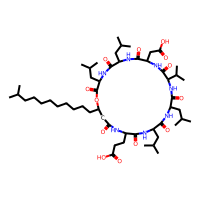
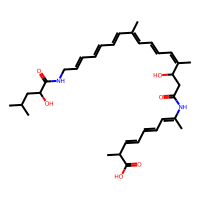
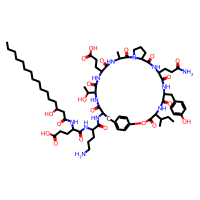
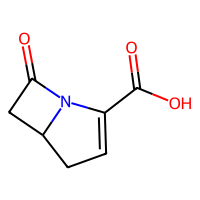
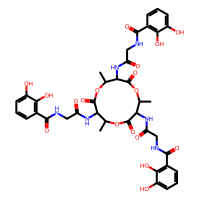
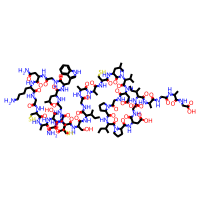
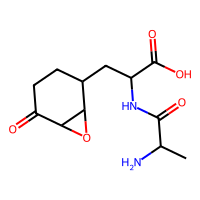

In [237]:
anti_paper2

In [238]:
raw_data

[      pubid                                           Abstract    surfactin  \
 0  29269072  Members of the Bacillaceae family, including B...  0         0   
 1  32360573  Biosurfactants (BSs) molecules are classically...  0         0   
 2  28685194  The lipopeptides of Bacillus are small metabol...  0         0   
 3  36578512  Increasing food demand by the ever-growing pop...  0         0   
 4  35671583  Given the risk of Candida albicans overgrowth ...  0         9   
 
   antibacterial antimicrobial antifungal antimycotic fungicide sum_func  
 0             0             0          0           0         0        0  
 1             0             0          0           0         0        0  
 2             0             0          0           0         0        0  
 3             0             2          0           0         0        2  
 4             0             0          1           0         0        1  ,
       pubid                                           Abstract    